In [1]:
import pandas as pd
import numpy as np
import pickle

# Definimos path
pathdata = '/Users/danielarisaro/Documents/Fundar/indice-mercado-trabajo-ingresos/'
pathdata = '/home/daniufundar/Documents/Fundar/indice-mercado-trabajo-ingresos/'

with open(pathdata + 'modulos/diccionarios/' + 'diccionario_aglomerados.pickle', 'rb') as file:
    dict_cod_aglomerado = pickle.load(file)

with open(pathdata + 'modulos/diccionarios/' + 'diccionario_provincia.pickle', 'rb') as file:
    dict_cod_provincia = pickle.load(file)

with open(pathdata + 'modulos/diccionarios/' + 'diccionario_aglomerado_provincia.pickle', 'rb') as file:
    map_aglomerado_provincia = pickle.load(file)

with open(pathdata + 'modulos/diccionarios/' + 'diccionario_aglomerado_region.pickle', 'rb') as file:
    map_aglomerado_region = pickle.load(file)

with open(pathdata + 'modulos/diccionarios/' + 'diccionario_provincia_region.pickle', 'rb') as file:
    map_provincia_region = pickle.load(file)

df_CBT = pd.read_csv(pathdata + 'data_output/Canasta_Basica_Total_Regiones_2016-2022-promedios-moviles.csv', delimiter=',', header=0, index_col=[0])
df_adultos_equiv = pd.read_csv(pathdata + 'data_input/canastas_basicas/adultos_equivalente.csv')

def capitalize_first_letter(s):
    return s.capitalize()

df_CBT = df_CBT.rename(columns=capitalize_first_letter)
df_CBT.rename(columns={'Gran_buenos_aires':'Gran Buenos Aires'}, inplace=True)

df_people_pool = pd.read_csv(pathdata + 'data_output/Base_pool_individuos_solo_con_replicas_actuales.csv', low_memory=False, index_col=0)
df_houses_pool = pd.read_csv(pathdata + 'data_output/Base_pool_hogares_solo_con_replicas_actuales.csv', low_memory=False, index_col=0)

pondera = 'PONDERA_new'
var = 'PROVINCIA'
df_temp = df_people_pool.query('CH06 >= 14')

# Diccionario regiones ENUT
dict_regiones_ENUT = {1: 'Gran Buenos Aires',
                    2: 'Pampeana',
                    3: 'Noroeste',
                    4: 'Noreste',
                    5: 'Cuyo',
                    6: 'Patagonia'}

# Cargo ENUT
pathfolder_ENUT =  pathdata + 'data_input/ENUT_2021/Bases de datos/'
filename = 'enut2021_base.txt'
df_enut = pd.read_csv(pathfolder_ENUT + filename, sep='|')
columnas = pd.DataFrame(df_enut.columns)

## Indicadores

In [2]:
df_ocupados = df_temp[df_temp['ESTADO']==1][[var, pondera, 'CH04']]

tot_ocupados = df_ocupados.groupby('CH04')[pondera].sum()


In [4]:
## Cargo y ordeno los indicadores

ratio_actividad = pd.read_csv(pathdata + 'data_output/indicadores/01_ratio_actividad.csv', index_col=0)
empleo_asalariado_con_descuento = pd.read_csv(pathdata + 'data_output/indicadores/02_empleo_asalariado_con_descuento.csv', index_col=0)
horas_remuneradas_media = pd.read_csv(pathdata + 'data_output/indicadores/03_horas_promedio_ocup_ppal.csv', index_col=0)
ingreso_salarial_media = pd.read_csv(pathdata + 'data_output/indicadores/04_ingreso_salarial.csv', index_col=0)
ratio_minutos_promedio_no_pago = pd.read_csv(pathdata + 'data_output/indicadores/05_tiempo_no_remunerado.csv', index_col=0)
inactivos_con_ingreso = pd.read_csv(pathdata + 'data_output/indicadores/06_dependencia_economica.csv', index_col=0)
hogares_jefatura = pd.read_csv(pathdata + 'data_output/indicadores/07_hogares_no-pobres_jefatura.csv', index_col=0)

ratio_actividad = ratio_actividad.sort_index()
empleo_asalariado_con_descuento = empleo_asalariado_con_descuento.sort_index()
horas_remuneradas_media = horas_remuneradas_media.sort_index()
ingreso_salarial_media = ingreso_salarial_media.sort_index()
ratio_minutos_promedio_no_pago = ratio_minutos_promedio_no_pago.sort_index()
inactivos_con_ingreso = inactivos_con_ingreso.sort_index()
hogares_jefatura = hogares_jefatura.sort_index()


In [3]:
## Empleo publico

df_ocupados = df_temp[df_temp['ESTADO']==1][[var, pondera, 'CH04']]
df_ocupados_publico = df_temp[(df_temp['ESTADO']==1) & (df_temp['PP04A']==1)][[var, pondera, 'CH04']]
df_tasa = df_ocupados_publico.groupby(['CH04',var])[pondera].sum() / df_ocupados.groupby(['CH04',var])[pondera].sum()
df_empleo_publico = df_tasa.unstack(level=0)*100
df_empleo_publico = df_empleo_publico.rename(columns={1:'Varon', 2:'Mujer'})
df_empleo_publico['Ratio'] = df_empleo_publico['Mujer']/df_empleo_publico['Varon']*100
df_empleo_publico.index = df_empleo_publico.index.map(dict_cod_provincia)

size = df_ocupados_publico.groupby(['CH04', var]).size().unstack(level=0)
size = size.rename(columns= {1:'N_v', 2:'N_m'})
n_pob = df_ocupados_publico.groupby(['CH04', var])[pondera].sum().unstack(level=0)
n_pob = n_pob.rename(columns= {1:'N_pob_v', 2:'N_pob_m'})
size[['N_pob_v', 'N_pob_m']] = n_pob[['N_pob_v', 'N_pob_m']]
size['N_pob_tot'] = n_pob['N_pob_v'] + n_pob['N_pob_m']
size.index = size.index.map(dict_cod_provincia)
empleo_publico = pd.concat([df_empleo_publico, size], axis=1)
empleo_publico = empleo_publico.sort_index()
empleo_publico.to_csv(pathdata + 'data_output/indicadores_auxiliares/01_empleo_publico.csv')

In [27]:
empleo_asalariado_con_descuento[['Mujer','Varon']].round(1)

,Mujer,Varon
PROVINCIA,,
Buenos Aires,60.2,64.2
CABA,74.5,78.9
Catamarca,60.6,61.8
Chaco,57.1,45.8
Chubut,71.2,79.3
Corrientes,53.5,54.9
Córdoba,50.6,54.2
Entre Ríos,57.0,65.8
Formosa,57.6,50.7


array([[1.        , 0.39449709],
       [0.39449709, 1.        ]])

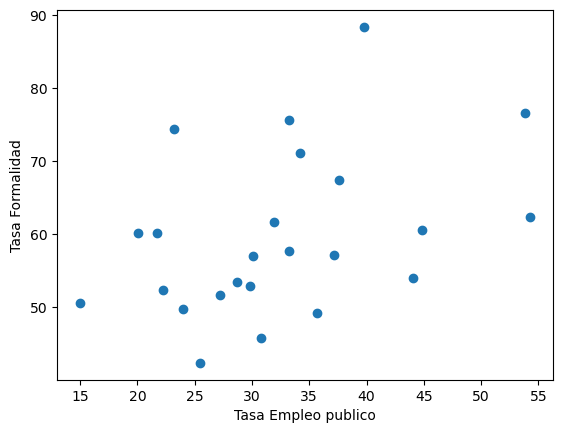

In [16]:
import matplotlib.pyplot as plt
plt.scatter(empleo_publico['Mujer'], empleo_asalariado_con_descuento['Mujer'])
plt.xlabel('Tasa Empleo publico')
plt.ylabel('Tasa Formalidad')
np.corrcoef(empleo_publico['Mujer'], empleo_asalariado_con_descuento['Mujer'])

In [20]:
pd.concat([empleo_publico['Mujer'], empleo_asalariado_con_descuento['Mujer']], axis=1).mean()

Mujer    32.419673
Mujer    59.679715
dtype: float64

In [22]:
pd.concat([empleo_publico['Mujer'], empleo_asalariado_con_descuento['Mujer']], axis=1).sort_index().to_clipboard()

In [4]:
## Distribución de población ocupada, según intensidad laboral

df_ocupados_intensi = df_temp[(df_temp['ESTADO']==1)][[var, pondera, 'CH04','INTENSI']]
df_tasa = df_ocupados_intensi.groupby(['CH04',var,'INTENSI'])[pondera].sum()/df_ocupados_intensi.groupby(['CH04',var])[pondera].sum()
df_intensidad_laboral = df_tasa.unstack(level=0)*100
df_intensidad_laboral = df_intensidad_laboral.rename(columns={1:'Varon', 2:'Mujer'})
df_intensidad_laboral['Ratio'] = df_intensidad_laboral['Mujer']/df_intensidad_laboral['Varon']*100
new_index = df_intensidad_laboral.index.get_level_values('PROVINCIA').map(dict_cod_provincia)
df_intensidad_laboral.index = pd.MultiIndex.from_tuples(zip(new_index, df_intensidad_laboral.index.get_level_values('INTENSI')), names=['PROVINCIA', 'INTENSI'])

size = df_ocupados_intensi.groupby(['CH04', var, 'INTENSI']).size().unstack(level=0)
size = size.rename(columns= {1:'N_v', 2:'N_m'})
size.index = pd.MultiIndex.from_tuples(zip(new_index, size.index.get_level_values('INTENSI')), names=['PROVINCIA', 'INTENSI'])

n_pob = df_ocupados_intensi.groupby(['CH04', var, 'INTENSI'])[pondera].sum().unstack(level=0)
n_pob = n_pob.rename(columns= {1:'N_pob_v', 2:'N_pob_m'})
n_pob.index = pd.MultiIndex.from_tuples(zip(new_index, n_pob.index.get_level_values('INTENSI')), names=['PROVINCIA', 'INTENSI'])

size[['N_pob_v', 'N_pob_m']] = n_pob[['N_pob_v', 'N_pob_m']]
size['N_pob_tot'] = n_pob['N_pob_v'] + n_pob['N_pob_m']
intensidad_laboral = pd.concat([df_intensidad_laboral, size], axis=1)
intensidad_laboral = intensidad_laboral.sort_index()

intensidad_laboral.to_csv(pathdata + 'data_output/indicadores_auxiliares/02_intensidad_laboral.csv')

In [5]:
## Distribución de población ocupada según máximo nivel educativo alcanzado

df_ocupados_educacion = df_temp[(df_temp['ESTADO']==1)][[var, pondera, 'CH04','CH12','CH13']]
df_ocupados_educacion['Educacion'] = pd.NaT

df_ocupados_educacion.loc[(df_ocupados_educacion['CH12'].isin([1,2,3,9])),'Educacion'] = 'Hasta secundario incompleto'
df_ocupados_educacion.loc[(df_ocupados_educacion['CH12'].isin([4,5])) & (df_ocupados_educacion['CH13']==2),'Educacion'] = 'Hasta secundario incompleto'
df_ocupados_educacion.loc[(df_ocupados_educacion['CH12'].isin([4,5])) & (df_ocupados_educacion['CH13']==1),'Educacion'] = 'Secundario completo'
df_ocupados_educacion.loc[df_ocupados_educacion['CH12'].isin([6,7,8]),'Educacion'] = 'Educación superior'
df_ocupados_educacion = df_ocupados_educacion[~df_ocupados_educacion['Educacion'].isna()]

df_tasa = df_ocupados_educacion.groupby(['CH04',var,'Educacion'])[pondera].sum()/df_ocupados_educacion.groupby(['CH04',var])[pondera].sum()

df_educacion = df_tasa.unstack(level=0)*100
df_educacion = df_educacion.rename(columns={1:'Varon', 2:'Mujer'})
df_educacion['Ratio'] = df_educacion['Mujer']/df_educacion['Varon']*100

new_index = df_educacion.index.get_level_values('PROVINCIA').map(dict_cod_provincia)
df_educacion.index = pd.MultiIndex.from_tuples(zip(new_index, df_educacion.index.get_level_values('Educacion')), names=['PROVINCIA', 'Educacion'])

size = df_ocupados_educacion.groupby(['CH04', var, 'Educacion']).size().unstack(level=0)
size = size.rename(columns= {1:'N_v', 2:'N_m'})
size.index = pd.MultiIndex.from_tuples(zip(new_index, size.index.get_level_values('Educacion')), names=['PROVINCIA', 'Educacion'])

n_pob = df_ocupados_educacion.groupby(['CH04', var, 'Educacion'])[pondera].sum().unstack(level=0)
n_pob = n_pob.rename(columns= {1:'N_pob_v', 2:'N_pob_m'})
n_pob.index = pd.MultiIndex.from_tuples(zip(new_index, n_pob.index.get_level_values('Educacion')), names=['PROVINCIA', 'Educacion'])

size[['N_pob_v', 'N_pob_m']] = n_pob[['N_pob_v', 'N_pob_m']]
size['N_pob_tot'] = n_pob['N_pob_v'] + n_pob['N_pob_m']

educacion = pd.concat([df_educacion, size], axis=1)
educacion = educacion.sort_index()

educacion.to_csv(pathdata + 'data_output/indicadores_auxiliares/03_maximo_nivel_educativo.csv')

In [6]:
## Distribución de población ocupada / activa, según categorías ocupacionales (patrón, asalariado, cuentapropia, TFSR)

df_cat_ocup = df_temp[(df_temp['ESTADO']==1)][[var, pondera, 'CH04', 'CAT_OCUP']]
df_tasa = df_cat_ocup.groupby(['CH04',var,'CAT_OCUP'])[pondera].sum()/df_cat_ocup.groupby(['CH04',var])[pondera].sum()
df_poblacion_ocupada = df_tasa.unstack(level=0)*100
df_poblacion_ocupada = df_poblacion_ocupada.rename(columns={1:'Varon', 2:'Mujer'})
df_poblacion_ocupada['Ratio'] = df_poblacion_ocupada['Mujer']/df_poblacion_ocupada['Varon']*100
new_index = df_poblacion_ocupada.index.get_level_values('PROVINCIA').map(dict_cod_provincia)
df_poblacion_ocupada.index = pd.MultiIndex.from_tuples(zip(new_index, df_poblacion_ocupada.index.get_level_values('CAT_OCUP')), names=['PROVINCIA', 'CAT_OCUP'])

size = df_cat_ocup.groupby(['CH04', var, 'CAT_OCUP']).size().unstack(level=0)
size = size.rename(columns= {1:'N_v', 2:'N_m'})
size.index = pd.MultiIndex.from_tuples(zip(new_index, size.index.get_level_values('CAT_OCUP')), names=['PROVINCIA', 'CAT_OCUP'])

n_pob = df_cat_ocup.groupby(['CH04', var, 'CAT_OCUP'])[pondera].sum().unstack(level=0)
n_pob = n_pob.rename(columns= {1:'N_pob_v', 2:'N_pob_m'})
n_pob.index = pd.MultiIndex.from_tuples(zip(new_index, n_pob.index.get_level_values('CAT_OCUP')), names=['PROVINCIA', 'CAT_OCUP'])

size[['N_pob_v', 'N_pob_m']] = n_pob[['N_pob_v', 'N_pob_m']]
size['N_pob_tot'] = n_pob['N_pob_v'] + n_pob['N_pob_m']
categorias_ocupacionales = pd.concat([df_poblacion_ocupada, size], axis=1)
categorias_ocupacionales = categorias_ocupacionales.sort_index()
categorias_ocupacionales.to_csv(pathdata + 'data_output/indicadores_auxiliares/04_categorias_ocupacionales.csv')

In [7]:
## Distribución de población asalariada, según descuento jubilatorio (con/sin) y aporte propio (con/sin)
#%run /Users/danielarisaro/Documents/Fundar/indice-mercado-trabajo-ingresos/modulos/funciones/01_funciones_insercion_laboral.ipynb
%run /home/daniufundar/Documents/Fundar/indice-mercado-trabajo-ingresos/modulos/funciones/01_funciones_insercion_laboral.ipynb

resultados, tabla_pob_ocupada_asalariada = calcular_tabla_poblacion_ocupada_asalariada(df_people_pool, tipo='Aglomerado', base='Individual', pool=True)
resultados.to_csv(pathdata + 'data_output/indicadores_auxiliares/05_poblacion_asalariada.csv')

In [8]:
## Tasa de pluriempleo nacional

df_pluriempleo = df_temp[(df_temp['ESTADO']==1)][[var, pondera, 'CH04', 'PP03C', 'PP03D', 'PP04B1', 'PP04B2']]
cond1 = df_pluriempleo['PP03C'].isin([0, 1])
cond2 = df_pluriempleo['PP03C'] == 2
cond3 = (df_pluriempleo['PP03D'] > 1) & (df_pluriempleo['PP04B1'] == 1) & (df_pluriempleo['PP04B2'] > 2)

qv_tot = df_pluriempleo.groupby('CH04')[pondera].sum()

#resultados = pd.DataFrame(index=['PP03C==0 | PP03C==1', 'PP03C==2', 'PP03D>1 & PP04B1==1 & PP04B2>2', 'Total Col'], columns=[ 'Varones', 'Mujeres', 'Total V + M', '% Varones', '% Mujeres', 'Ratio', ])
resultados = pd.DataFrame(index=['PP03C==0 | PP03C==1', 'PP03C==2', 'Total Col'], columns=[ 'Varones', 'Mujeres', 'Total V + M', '% Varones', '% Mujeres', 'Ratio', ])

resultados.loc['PP03C==0 | PP03C==1',['Varones', 'Mujeres']] = df_pluriempleo[cond1].groupby('CH04')[pondera].sum().sort_index().values
resultados.loc['PP03C==2',['Varones', 'Mujeres']] = df_pluriempleo[cond2].groupby('CH04')[pondera].sum().sort_index().values
#resultados.loc['PP03D>1 & PP04B1==1 & PP04B2>2',['Varones', 'Mujeres']] = df_pluriempleo[cond3].groupby('CH04')[pondera].sum().sort_index().values
resultados['Total V + M'] = resultados['Varones'] + resultados['Mujeres']

resultados.loc['Total Col'] = resultados.sum(axis=0)

resultados.loc[:, '% Varones'] = resultados['Varones'] / resultados.loc['Total Col', 'Varones'] * 100
resultados.loc[:, '% Mujeres'] = resultados['Mujeres'] / resultados.loc['Total Col', 'Mujeres'] * 100
resultados.loc[:, 'Ratio'] = resultados['% Mujeres'] / resultados['% Varones']

resultados.to_csv(pathdata + 'data_output/indicadores_auxiliares/06_pluriempleo_nacional.csv')   

In [9]:
## Absolutos pluriempleo nacional

df1 = df_pluriempleo[cond1].groupby([var, 'CH04'])[pondera].sum().unstack(level=1).rename(columns={1: 'Varones PP03C==0 | PP03C==1', 2: 'Mujeres PP03C==0 | PP03C==1'})
df1_size = df_pluriempleo[cond1].groupby([var, 'CH04'])[pondera].size().unstack(level=1).rename(columns={1: 'Nv', 2: 'Nm'})

df2 = df_pluriempleo[cond2].groupby([var, 'CH04'])[pondera].sum().unstack(level=1).rename(columns={1: 'Varones PP03C==2', 2: 'Mujeres PP03C==2'})
df2_size = df_pluriempleo[cond2].groupby([var, 'CH04'])[pondera].size().unstack(level=1).rename(columns={1: 'Nv', 2: 'Nm'})

df3 = df_pluriempleo[cond3].groupby([var, 'CH04'])[pondera].sum().unstack(level=1).rename(columns={1: 'Varones PP03D>1 & PP04B1==1 & PP04B2>2', 2: 'Mujeres PP03D>1 & PP04B1==1 & PP04B2>2'})
df3_size = df_pluriempleo[cond3].groupby([var, 'CH04'])[pondera].size().unstack(level=1).rename(columns={1: 'Nv', 2: 'Nm'})

## Agregar los porcentajes. 

pluriempleo_absolutos = pd.concat([df1, df1_size, df2, df2_size, df3, df3_size], axis=1)

pluriempleo_absolutos.index = pluriempleo_absolutos.index.map(dict_cod_provincia)
pluriempleo_absolutos.to_csv(pathdata + 'data_output/indicadores_auxiliares/07_pluriempleo_provincial_absolutos.csv')    

In [10]:
## Ingresos laborales secundarios

pondera = 'PONDII' 
df_ocupados = df_temp[(df_temp['ESTADO']==1)][[var, pondera, 'TOT_P12_new', 'CH04']]
df_ocupados = df_ocupados[(df_ocupados['TOT_P12_new']>0) & (df_ocupados['TOT_P12_new']!=-9)]
df_ocupados['Multiplication'] = df_ocupados['TOT_P12_new'] * df_ocupados[pondera]
numerador = df_ocupados.groupby(['CH04', var])['Multiplication'].sum().unstack(level=0)
denominador = df_ocupados.groupby(['CH04', var])[pondera].sum().unstack(level=0)

size = df_ocupados.groupby(['CH04', var]).size().unstack(level=0)
size = size.rename(columns= {1:'N_v', 2:'N_m'})
n_pob = df_ocupados.groupby(['CH04', var])[pondera].sum().unstack(level=0)
n_pob = n_pob.rename(columns= {1:'N_pob_v', 2:'N_pob_m'})
size[['N_pob_v', 'N_pob_m']] = n_pob[['N_pob_v', 'N_pob_m']]
size['N_pob_tot'] = n_pob['N_pob_v'] + n_pob['N_pob_m']

tasa = numerador.div(denominador, fill_value=np.nan).rename(columns={1: 'Varon', 2: 'Mujer'}) 
tasa.loc[:, 'Ratio'] = tasa['Mujer']/tasa['Varon']*100
ingresos_laborales_secundarios = pd.concat([tasa, size], axis=1)
ingresos_laborales_secundarios.index = ingresos_laborales_secundarios.index.map(dict_cod_provincia)
ingresos_laborales_secundarios = ingresos_laborales_secundarios.sort_index()
ingresos_laborales_secundarios.to_csv(pathdata + 'data_output/indicadores_auxiliares/08_ingresos_laborales_secundarios.csv')

In [11]:
## Ingreso secundario
#%run /Users/danielarisaro/Documents/Fundar/indice-mercado-trabajo-ingresos/modulos/funciones/01_funciones_insercion_laboral.ipynb
%run /home/daniufundar/Documents/Fundar/indice-mercado-trabajo-ingresos/modulos/funciones/01_funciones_insercion_laboral.ipynb

tasa, size, ratio, error = horas_promedio_remuneradas_secundarias(df_people_pool, tipo='Urbano', base='Individual', confidence_level=0.95, pool=True)
horas_trabajadas_secundarias = pd.concat([tasa, size, ratio], axis=1)
horas_trabajadas_secundarias.index = horas_trabajadas_secundarias.index.map(dict_cod_provincia)
horas_trabajadas_secundarias = horas_trabajadas_secundarias.sort_index()
horas_trabajadas_secundarias.to_csv(pathdata + 'data_output/indicadores_auxiliares/09_horas_remuneradas_secundarias.csv')    

In [12]:
## Distribución de conyugalidad
#%run /Users/danielarisaro/Documents/Fundar/indice-mercado-trabajo-ingresos/modulos/funciones/02_funciones_autonomia_economica.ipynb
%run /home/daniufundar/Documents/Fundar/indice-mercado-trabajo-ingresos/modulos/funciones/02_funciones_autonomia_economica.ipynb

grouped_df = calculate_poverty_table(df_people_pool, df_houses_pool, df_CBT, df_adultos_equiv, dict_cod_provincia, map_provincia_region)
sin_conyuges = grouped_df[grouped_df['CH03'].apply(lambda x: 2 not in x)].groupby(['GENDER_PERSON_IN_CHARGE'])['INCOME_PONDERATOR'].sum()
con_conyuges = grouped_df[grouped_df['CH03'].apply(lambda x: 2 in x)].groupby(['GENDER_PERSON_IN_CHARGE'])['INCOME_PONDERATOR'].sum()
df_jefatura = pd.DataFrame(index=['Con conyuge', 'Sin conyuge', 'Total Col'], columns=['Varones', '% Varones', 'Mujeres', '% Mujeres', 'Total Fila'])
df_jefatura.loc['Con conyuge', ['Varones', 'Mujeres']] = con_conyuges[['MALE','FEMALE']].values
df_jefatura.loc['Sin conyuge', ['Varones', 'Mujeres']] = sin_conyuges[['MALE','FEMALE']].values
df_jefatura['Total Fila'] = df_jefatura['Varones'] + df_jefatura['Mujeres']
df_jefatura.loc['Total Col', ['Varones', 'Mujeres', 'Total Fila']] = df_jefatura[['Varones', 'Mujeres', 'Total Fila']].sum(axis=0)
df_jefatura.loc[:, '% Varones'] = df_jefatura['Varones'] / df_jefatura.loc['Total Col', 'Varones'] * 100
df_jefatura.loc[:, '% Mujeres'] = df_jefatura['Mujeres'] / df_jefatura.loc['Total Col', 'Mujeres'] * 100
df_jefatura.to_csv(pathdata + 'data_output/indicadores_auxiliares/11_distribucion_conyuges.csv')

In [13]:
def numero_a_letra(numero):

    if 101 <= numero <= 300 or 1 <= numero <= 3:
        return 'A'
    elif 500 <= numero <= 900 or 5 <= numero <= 9:
        return 'B'
    elif 1001 <= numero <= 3300 or 10 <= numero <= 33:
        return 'C'
    elif numero in [3501, 3502] or numero==35:
        return 'D'
    elif 3600 <= numero <= 3900 or 36 <= numero <= 39:
        return 'E'
    elif numero == 4000 or numero == 40:
        return 'F'
    elif 4501 <= numero <= 4811 or 45 <= numero <= 48:
        return 'G'
    elif 4901 <= numero <= 5300 or 49 <= numero <= 53:
        return 'H'
    elif 5500 <= numero <= 5602 or 55 <= numero <= 56:
        return 'I'
    elif 5800 <= numero <= 6300 or 58 <= numero <= 63:
        return 'J'
    elif 6400 <= numero <= 6600 or 64 <= numero <= 66:
        return 'K'
    elif numero == 6800 or numero == 68:
        return 'L'
    elif 6900 <= numero <= 7500 or 69 <= numero <= 75:
        return 'M'
    elif 7701 <= numero <= 8200 or 77 <= numero <= 82:
        return 'N'
    elif 8300 <= numero <= 8403 or 83 <= numero <= 84:
        return 'O'
    elif numero in [8501, 8509] or numero == 85:
        return 'P'
    elif 8600 <= numero <= 8800 or 86 <= numero <= 88:
        return 'Q'
    elif 9000 <= numero <= 9302 or 90 <= numero <= 93:
        return 'R'
    elif 9401 <= numero <= 9609 or 94 <= numero <= 96:
        return 'S'
    elif numero in [9700, 9800] or numero in [97, 98]:
        return 'T'
    elif numero == 9900 or numero == 99:
        return 'U'
    elif numero == 9999:
        return 'Desconocido'

In [14]:
map_ramas_actividad = {'A':'Produccion', 
                    'B':'Produccion',
                    'C':'Produccion',
                    'F':'Produccion',
                    'H':'Produccion',
                    'G':'Comercio',
                    'I':'Hoteleria y comidas',
                    'P':'Enseñanza',
                    'Q':'Enseñanza',
                    'J':'Servicios',
                    'K':'Servicios',
                    'L':'Servicios',
                    'M':'Servicios',
                    'N':'Servicios',
                    'S':'Servicios',                
                    'O':'Adm publica',
                    'T':'Servicio domestico',
                    'D':'Otras',
                    'E':'Otras',
                    'R':'Otras',
                    'U':'Otras',
                    'Z':'Otras'}

In [15]:
pondera = 'PONDERA_new'
var = 'PROVINCIA'
df_temp = df_people_pool.query('CH06 >= 14')
df_rama_actividad = df_temp[df_temp['ESTADO']==1][[var, pondera, 'CH04', 'PP04B_COD']]
df_rama_actividad['Letra_COD'] = df_rama_actividad['PP04B_COD'].apply(numero_a_letra)
df_rama_actividad['Agrupamiento'] = df_rama_actividad['Letra_COD'].map(map_ramas_actividad)
df_ocupados_rama_actividad = df_rama_actividad[[var, pondera, 'CH04','Agrupamiento']]
df_tasa = df_ocupados_rama_actividad.groupby(['CH04',var,'Agrupamiento'])[pondera].sum()/df_ocupados_rama_actividad.groupby(['CH04',var])[pondera].sum()
df_agrupamiento_ramas = df_tasa.unstack(level=0)*100
df_agrupamiento_ramas = df_agrupamiento_ramas.rename(columns={1:'Varon', 2:'Mujer'})
df_agrupamiento_ramas['Ratio'] = df_agrupamiento_ramas['Mujer']/df_agrupamiento_ramas['Varon']*100
new_index = df_agrupamiento_ramas.index.get_level_values('PROVINCIA').map(dict_cod_provincia)
df_agrupamiento_ramas.index = pd.MultiIndex.from_tuples(zip(new_index, df_agrupamiento_ramas.index.get_level_values('Agrupamiento')), names=['PROVINCIA', 'Agrupamiento'])

size = df_ocupados_rama_actividad.groupby(['CH04', var, 'Agrupamiento']).size().unstack(level=0)
size = size.rename(columns= {1:'N_v', 2:'N_m'})
size.index = pd.MultiIndex.from_tuples(zip(new_index, size.index.get_level_values('Agrupamiento')), names=['PROVINCIA', 'Agrupamiento'])

n_pob = df_ocupados_rama_actividad.groupby(['CH04', var, 'Agrupamiento'])[pondera].sum().unstack(level=0)
n_pob = n_pob.rename(columns= {1:'N_pob_v', 2:'N_pob_m'})
n_pob.index = pd.MultiIndex.from_tuples(zip(new_index, n_pob.index.get_level_values('Agrupamiento')), names=['PROVINCIA', 'Agrupamiento'])

size[['N_pob_v', 'N_pob_m']] = n_pob[['N_pob_v', 'N_pob_m']]
size['N_pob_tot'] = n_pob['N_pob_v'] + n_pob['N_pob_m']
ramas_actividad = pd.concat([df_agrupamiento_ramas, size], axis=1)
ramas_actividad = ramas_actividad.sort_index()
ramas_actividad
ramas_actividad.to_csv(pathdata + 'data_output/indicadores_auxiliares/12_ramas_actividad.csv')

In [18]:
ramas_actividad.to_clipboard()

CH04
Varon    12.026458
Mujer    12.159450
dtype: float64

In [47]:
result[['Varon', 'Mujer']].mean()

CH04
Varon     7.123853
Mujer    25.162295
dtype: float64

In [50]:
ramas = ['Enseñanza', 'Produccion','Servicio domestico']

for i, iram in enumerate(ramas):
    print(iram)
    result = ramas_actividad.loc[ramas_actividad.index.get_level_values(1) == iram]
    print(result[['Varon', 'Mujer']].std() / result[['Varon', 'Mujer']].mean())



Enseñanza
CH04
Varon    0.253614
Mujer    0.110502
dtype: float64
Produccion
CH04
Varon    0.149813
Mujer    0.251864
dtype: float64
Servicio domestico
CH04
Varon    0.545741
Mujer    0.237239
dtype: float64


In [28]:
result = ramas_actividad.loc[ramas_actividad.index.get_level_values(1) == 'Comercio']


MultiIndex([('Buenos Aires',         'Adm publica'),
            ('Buenos Aires',            'Comercio'),
            ('Buenos Aires',           'Enseñanza'),
            ('Buenos Aires', 'Hoteleria y comidas'),
            ('Buenos Aires',               'Otras'),
            ('Buenos Aires',          'Produccion'),
            ('Buenos Aires',  'Servicio domestico'),
            ('Buenos Aires',           'Servicios'),
            (        'CABA',         'Adm publica'),
            (        'CABA',            'Comercio'),
            ...
            (         'TdF',  'Servicio domestico'),
            (         'TdF',           'Servicios'),
            (     'Tucumán',         'Adm publica'),
            (     'Tucumán',            'Comercio'),
            (     'Tucumán',           'Enseñanza'),
            (     'Tucumán', 'Hoteleria y comidas'),
            (     'Tucumán',               'Otras'),
            (     'Tucumán',          'Produccion'),
            (     'Tucumán',  

In [ ]:
ratio_actividad

In [19]:
ramas_actividad['Agrupamiento']

KeyError: 'Agrupamiento'

### ENUT

In [20]:
## Calculo coeficientes para imputar a PBA
df_temp = df_people_pool[df_people_pool['CH06']>14]
df_pob = df_temp.groupby(['AGLOMERADO']).sum(['PONDERA_new'])
df_pob.index = df_pob.index.map(dict_cod_aglomerado)
df_pob['PROVINCIA'] = df_pob.index.map(map_aglomerado_provincia)
pob_pba = df_pob[df_pob['PROVINCIA']=='Buenos Aires']['PONDERA_new'].sum()
gba = df_pob[df_pob['PROVINCIA']=='Buenos Aires'].loc['Partidos del GBA', 'PONDERA_new']
resto_pba = df_pob[df_pob['PROVINCIA']=='Buenos Aires'].loc[['Gran La Plata', 'Bahía Blanca - Cerri', 'Mar del Plata', 'Resto Buenos Aires'], 'PONDERA_new'].sum()
coef_gba = gba/pob_pba
coef_resto_pba = resto_pba/pob_pba

In [21]:
# Calculo TNR
pondera = 'WPER'
df_temp_enut = df_enut[df_enut['EDAD_SEL']>=14]
df_selected = df_temp_enut[(~df_temp_enut['TCS_GRANGRUPO_TNR'].isna())][['TCS_GRANGRUPO_TNR', 'SEXO_SEL', 'REGION', pondera]]
df_selected['Multiplication'] = df_selected['TCS_GRANGRUPO_TNR'] * df_selected[pondera]

numerador = df_selected.groupby(['SEXO_SEL', 'REGION'])['Multiplication'].sum().unstack(level=0)
denominador = df_selected.groupby(['SEXO_SEL', 'REGION'])[pondera].sum().unstack(level=0)
tasa = numerador.div(denominador, fill_value=np.nan)    
tasa = tasa.rename(columns= {2:'Varon', 1:'Mujer'})

size = df_temp_enut[(~df_temp_enut['TCS_GRANGRUPO_TNR'].isna())].groupby(['REGION', 'SEXO_SEL']).size().unstack(level=1)
size = size.rename(columns= {2:'N_v', 1:'N_m'})

n_pob = df_temp_enut[(~df_temp_enut['TCS_GRANGRUPO_TNR'].isna())].groupby(['REGION', 'SEXO_SEL'])[pondera].sum().unstack(level=1)
n_pob = n_pob.rename(columns= {2:'N_pob_v', 1:'N_pob_m'})

size[['N_pob_v', 'N_pob_m']] = n_pob[['N_pob_v', 'N_pob_m']]
size['N_pob_tot'] = n_pob['N_pob_v'] + n_pob['N_pob_m'] 

ratio = tasa['Varon'] / tasa['Mujer']

error = pd.DataFrame(index=size.index, columns=['LI', 'LS', 'ME', 'ER'])

ratio_minutos_promedio_no_pago_tcs = pd.concat([tasa, size, ratio*100, error], axis=1)
ratio_minutos_promedio_no_pago_tcs.rename(columns={0: 'TCS TNR'}, inplace=True)

ratio_minutos_promedio_no_pago_tcs.index = ratio_minutos_promedio_no_pago_tcs.index.map(dict_regiones_ENUT)

# Imputo de regiones a provincias
map_provincia_region['Ciudad Autónoma de Buenos Aires'] = 'Gran Buenos Aires'
provincias = list(map_provincia_region.keys())
regiones = [map_provincia_region[provincia] for provincia in provincias]

ratio_minutos_promedio_no_pago_tcs_provincial = pd.DataFrame(index=provincias, columns=['Mujer', 'Varon'])
for provincia in provincias:
    region = map_provincia_region[provincia]
    ratio_minutos_promedio_no_pago_tcs_provincial.loc[provincia,:] = ratio_minutos_promedio_no_pago_tcs.loc[region,['Mujer', 'Varon']]

ratio_minutos_promedio_no_pago_tcs_provincial.index.name = 'Provincia'

## Corrijo el caso de PBA
ratio_minutos_promedio_no_pago_tcs_provincial.loc['Buenos Aires', ['Mujer', 'Varon']] = ratio_minutos_promedio_no_pago_tcs.loc['Gran Buenos Aires', ['Mujer', 'Varon']]*coef_gba + \
                                        ratio_minutos_promedio_no_pago_tcs.loc['Pampeana', ['Mujer', 'Varon']]*coef_resto_pba

# Calculo ratio
ratio_minutos_promedio_no_pago_tcs_provincial['TCS TNR'] = ratio_minutos_promedio_no_pago_tcs_provincial['Varon'] / ratio_minutos_promedio_no_pago_tcs_provincial['Mujer']*100
ratio_minutos_promedio_no_pago_tcs_provincial = ratio_minutos_promedio_no_pago_tcs_provincial.rename(index={'Ciudad Autónoma de Buenos Aires':'CABA', 'Tierra del Fuego, Antártida e Islas del Atlántico Sur':'TdF'})

# Exporto csv
ratio_minutos_promedio_no_pago_tcs = ratio_minutos_promedio_no_pago_tcs.sort_index()
ratio_minutos_promedio_no_pago_tcs_provincial = ratio_minutos_promedio_no_pago_tcs_provincial.sort_index()

ratio_minutos_promedio_no_pago_tcs_provincial.to_csv(pathdata + 'data_output/indicadores_auxiliares/10_tiempo_no_remunerado_TCS.csv')
ratio_minutos_promedio_no_pago_tcs.to_csv(pathdata + 'data_output/indicadores_auxiliares/10_tiempo_no_remunerado_regional_TCS.csv')

In [28]:
# Calculo fraccion TSS en TNR
pondera = 'WPER'
df_temp_enut = df_enut[(df_enut['EDAD_SEL']>=14) & (~df_temp_enut['TSS_GRANGRUPO_TNR'].isna())][['TSS_GRANGRUPO_TNR',
        'TSS_GRUPO_DOMESTICO',
        'TSS_GRUPO_CUIDADO',
        'TSS_GRUPO_TNROTROSHOGARES_VOLUNTARIAS', 'SEXO_SEL', 'REGION', pondera]]

# Calcular las fracciones
df_temp_enut['Fraccion_DOMESTICO'] = df_temp_enut['TSS_GRUPO_DOMESTICO'] / df_temp_enut['TSS_GRANGRUPO_TNR'] * 100
df_temp_enut['Fraccion_CUIDADO'] = df_temp_enut['TSS_GRUPO_CUIDADO'] / df_temp_enut['TSS_GRANGRUPO_TNR'] * 100
df_temp_enut['Fraccion_TNROTROSHOGARES_VOLUNTARIAS'] = df_temp_enut['TSS_GRUPO_TNROTROSHOGARES_VOLUNTARIAS'] / df_temp_enut['TSS_GRANGRUPO_TNR'] * 100

listado_tss = ['Fraccion_DOMESTICO', 'Fraccion_CUIDADO', 'Fraccion_TNROTROSHOGARES_VOLUNTARIAS']
nombre_tabla_tss = ['13_Fraccion_DOMESTICO', '14_Fraccion_CUIDADO', '15_Fraccion_TNROTROSHOGARES_VOLUNTARIAS']

In [31]:
df_temp_enut

,TSS_GRANGRUPO_TNR,TSS_GRUPO_DOMESTICO,TSS_GRUPO_CUIDADO,TSS_GRUPO_TNROTROSHOGARES_VOLUNTARIAS,SEXO_SEL,REGION,WPER,Fraccion_DOMESTICO,Fraccion_CUIDADO,Fraccion_TNROTROSHOGARES_VOLUNTARIAS
0,180.0,180.0,0.0,0.0,2,1,1580,100.000000,0.000000,0.000000
1,100.0,100.0,0.0,0.0,1,1,2175,100.000000,0.000000,0.000000
2,240.0,240.0,0.0,0.0,1,1,5078,100.000000,0.000000,0.000000
3,355.0,0.0,0.0,355.0,2,1,2182,0.000000,0.000000,100.000000
4,70.0,70.0,0.0,0.0,2,1,10202,100.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
14345,0.0,0.0,0.0,0.0,2,6,536,NaN,NaN,NaN
14346,120.0,120.0,0.0,0.0,1,6,423,100.000000,0.000000,0.000000
14347,795.0,420.0,295.0,80.0,2,6,535,52.830189,37.106918,10.062893
14348,510.0,510.0,0.0,0.0,1,6,423,100.000000,0.000000,0.000000


In [64]:
df_selected.unstack(level=0)

SEXO_SEL,1,2
REGION,,
1,5.384936,5.019699
2,5.506801,5.194470
3,4.760598,4.894380
4,3.524919,4.225822
5,4.465198,5.417208
6,4.521144,5.239761


In [67]:
for i, ivar in enumerate(listado_tss):
    
    df_selected = df_temp_enut[(~df_temp_enut[ivar].isna())].groupby(['SEXO_SEL', 'REGION'])[ivar].mean().unstack(level=0)
    tasa = df_selected.rename(columns= {2:'Varon', 1:'Mujer'})
    ratio = tasa['Varon'] / tasa['Mujer']
    print(ratio)

REGION
1    1.023565
2    1.028368
3    1.077252
4    1.061394
5    1.028803
6    1.035970
dtype: float64
REGION
1    0.904549
2    0.891065
3    0.700402
4    0.746555
5    0.830080
6    0.796140
dtype: float64
REGION
1    0.932174
2    0.943283
3    1.028102
4    1.198842
5    1.213207
6    1.158946
dtype: float64


In [73]:
for i, ivar in enumerate(listado_tss):
    
    df_selected = df_temp_enut[(~df_temp_enut[ivar].isna())].groupby(['SEXO_SEL', 'REGION'])[ivar].mean().unstack(level=0)
    tasa = df_selected.rename(columns= {2:'Varon', 1:'Mujer'})
    ratio = tasa['Varon'] / tasa['Mujer']

    fraccion_tss = pd.concat([tasa, ratio*100], axis=1)
    fraccion_tss.rename(columns={0: ivar}, inplace=True)

    fraccion_tss.index = fraccion_tss.index.map(dict_regiones_ENUT)

    # Imputo de regiones a provincias
    map_provincia_region['Ciudad Autónoma de Buenos Aires'] = 'Gran Buenos Aires'
    provincias = list(map_provincia_region.keys())
    regiones = [map_provincia_region[provincia] for provincia in provincias]

    fraccion_tss_provincial = pd.DataFrame(index=provincias, columns=['Mujer', 'Varon'])
    for provincia in provincias:
        region = map_provincia_region[provincia]
        fraccion_tss_provincial.loc[provincia,:] = fraccion_tss.loc[region,['Mujer', 'Varon']]

    fraccion_tss_provincial.index.name = 'Provincia'

    ## Corrijo el caso de PBA
    fraccion_tss_provincial.loc['Buenos Aires', ['Mujer', 'Varon']] = fraccion_tss.loc['Gran Buenos Aires', ['Mujer', 'Varon']]*coef_gba + \
                                            fraccion_tss.loc['Pampeana', ['Mujer', 'Varon']]*coef_resto_pba

    # Calculo ratio
    fraccion_tss_provincial['TCS TNR'] = fraccion_tss_provincial['Varon'] / fraccion_tss_provincial['Mujer']*100
    fraccion_tss_provincial = fraccion_tss_provincial.rename(index={'Ciudad Autónoma de Buenos Aires':'CABA', 'Tierra del Fuego, Antártida e Islas del Atlántico Sur':'TdF'})

    # Exporto csv
    fraccion_tss = fraccion_tss.sort_index()
    fraccion_tss_provincial = fraccion_tss_provincial.sort_index()

    fraccion_tss_provincial.to_csv(pathdata + 'data_output/indicadores_auxiliares/' + nombre_tabla_tss[i] + '_tiempo_no_remunerado_TSS.csv')
    fraccion_tss.to_csv(pathdata + 'data_output/indicadores_auxiliares/' + nombre_tabla_tss[i] + '_tiempo_no_remunerado_regional_TSS.csv')


In [4]:
# Calculo para Juanma

df_people_3T2021 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_21.txt', low_memory=False, index_col=0, delimiter=';')
df_temp = df_people_3T2021.query('CH06 >= 14')

df_estado = df_temp[(df_temp['ESTADO']==1)]          # personas ocupadas
df_ocupados = df_temp[(df_temp['P21']!=-9) & (df_temp['ESTADO']==1) & (df_temp['CAT_OCUP']==3)][['PONDIIO', 'P21', 'CH04']]
df_ocupados = df_ocupados[df_ocupados['P21']>0]

df_ocupados['Multiplication'] = df_ocupados['P21'] * df_ocupados['PONDIIO']
numerador = df_ocupados.groupby(['CH04'])['Multiplication'].sum()
denominador = df_ocupados.groupby(['CH04'])['PONDIIO'].sum()
tasa = numerador.div(denominador, fill_value=np.nan)    
tasa = tasa.rename(index= {1:'Varon', 2:'Mujer'})
tasa.loc['Ratio'] = tasa['Mujer']/tasa['Varon']*100
tasa